## 라이브러리 호출

In [99]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
from bs4 import BeautifulSoup
import urllib.request
from nltk.corpus import stopwords
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from summa.summarizer import summarize
import requests

In [22]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [25]:
data.sample(10)

,headlines,text
95541,NASA planning moon-orbiting space station to e...,NASA is planning to build an astronaut-tended ...
34426,Every rapist should be hanged: Nirbhaya's mother,"The mother of Nirbhaya, the 2012 Delhi gangrap..."
28291,"Goalkeeper goes to opponent's half to attack, ...",Germany goalkeeper Manuel Neuer conceded a goa...
87055,"Southwest monsoon hits Kerala, North East",The Southwest monsoon hit Kerala and the North...
41882,UP Assembly passes anti-organised crime bill,The Uttar Pradesh Assembly on Tuesday passed t...
39047,I am depressed: Uncapped cricketer who won 4 a...,"Kerala all-rounder Jalaj Saxena, who has won f..."
26265,Croatian player had 102-degree fever ahead of ...,Croatian midfielder Ivan RakitiÃÂ has reveal...
34948,Is Hindu Terror your idea: BJP leader to Javed...,After lyricist Javed Akhtar slammed the NIA af...
10623,'Thugs of Hindostan' leaked online within hour...,Aamir Khan and Amitabh Bachchan starrer 'Thugs...
9730,China 5-star hotels' staff use same cloth to c...,A video has gone viral in China showing staff ...


## 데이터 전처리하기

In [26]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [27]:
# null값 확인하기
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


#### 불용어 처리하기

In [28]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [29]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [30]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text  # <br />, <a href = ...> 등의 HTML 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호로 닫힌 문자열 (...) 제거
    sentence = re.sub('"', '', sentence)  # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split()])  # 약어 정규화
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # m이 3개 이상이면 2개로 변경

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if word not in stop_words and len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens

In [31]:
# text 열에 전처리 함수 적용 (불용어 제거 포함)
data['text'] = data['text'].apply(lambda x: preprocess_sentence(x, remove_stopwords=True))

# headline 열에 전처리 함수 적용 (불용어 제거 미적용)
data['headlines'] = data['headlines'].apply(lambda x: preprocess_sentence(x, remove_stopwords=False))

In [33]:
data.sample(10)

,headlines,text
46285,pm modi condoles actress sridevi untimely demise,pm narendra modi expressed grief untimely demi...
42850,investors sue facebook say it violated its own...,facebook sued investors claimed suffered losse...
83902,if you don like my govt don use our roads andh...,andhra pradesh cm chandrababu naidu thursday s...
81901,jyoti structures first to face bankruptcy unde...,power infrastructure company jyoti structures ...
82363,man drinks liquid nitrogen in bar gets hole in...,year old man mistakenly drank liquid nitrogen ...
31302,jio files complaint against airtel over apple ...,reliance jio filed complaint airtel alleging o...
60233,startup organises open day event at cv raman h...,nearly children gathered nobel laureate cv ram...
29743,deeply sorry not proud of this season kohli to...,rcb captain virat kohli took twitter apologise...
25273,comcast drops its billion bid for st century fox,us broadcasting giant comcast formally withdra...
33448,couple caught having sex chased naked by polic...,couple caught sex field salisbury uk chased na...


In [36]:
data.replace('', np.nan, inplace=True)

In [37]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [38]:
data.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


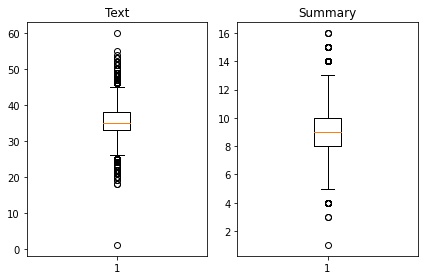

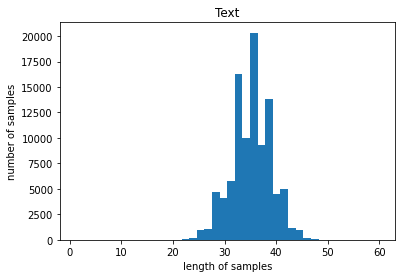

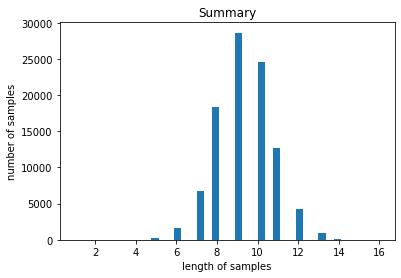

In [41]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(summary_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(summary_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [42]:
text_max_len = 50
headlines_max_len = 12

In [43]:
data = data[data.apply(lambda x: len(x['text'].split()) <= text_max_len and len(x['headlines'].split()) <= headlines_max_len, axis=1)]

In [44]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97169


In [64]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')


encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [65]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[15917 19048 39916 ... 62619 17031 29209]


In [66]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [67]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19433


In [68]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77736
훈련 레이블의 개수 : 77736
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


훈련데이터와 테스트 데이터의 개수를 잘 분리했다. 

### 정수인코딩

In [69]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [70]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69446
등장 빈도가 6번 이하인 희귀 단어의 수: 47410
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22036
단어 집합에서 희귀 단어의 비율: 68.2688707772946
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.529219062444004


In [71]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [72]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[353, 571, 636, 4187, 1301, 1250, 102, 3726, 40, 7, 323, 92, 629, 377, 66, 3065, 66, 348, 50, 6498, 4019, 149, 3745, 280, 92, 5782], [3893, 334, 59, 1, 30, 3562, 3028, 2, 7, 7007, 23, 1345, 915, 520, 2822, 667, 315, 509, 456, 3066, 6422, 124, 1087, 6746, 23, 1526, 317, 6746, 120, 315, 509, 1120, 4], [1518, 101, 2183, 1418, 5438, 198, 1342, 7848, 386, 4695, 667, 32, 493, 4696, 5439, 1418, 465, 985, 558, 558, 2776, 7214, 3542, 7307, 1, 121, 937]]


In [73]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [74]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29993
등장 빈도가 5번 이하인 희귀 단어의 수: 19596
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10397
단어 집합에서 희귀 단어의 비율: 65.33524489047444
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.700240169247795


In [75]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 353, 1231, 445, 5, 609, 70, 128], [1, 438, 24, 1030, 307, 1066, 1789, 6, 231, 1602], [1, 73, 452, 7, 133, 268], [1, 1878, 1819, 13, 84, 11, 21, 58], [1, 93, 217, 127, 405, 130, 4]]
target
decoder  [[353, 1231, 445, 5, 609, 70, 128, 2], [438, 24, 1030, 307, 1066, 1789, 6, 231, 1602, 2], [73, 452, 7, 133, 268, 2], [1878, 1819, 13, 84, 11, 21, 58, 2], [93, 217, 127, 405, 130, 4, 2]]


In [76]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 11
삭제할 테스트 데이터의 개수 : 6
훈련 데이터의 개수 : 77725
훈련 레이블의 개수 : 77725
테스트 데이터의 개수 : 19427
테스트 레이블의 개수 : 19427


In [77]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='pre')
print('=3')

=3


## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [114]:
# 인코더 설계
embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


In [115]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])


In [116]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 128)      1024000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 50, 256), (N 394240      embedding_3[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [117]:
from tensorflow.keras.layers import AdditiveAttention
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 최종 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 128)      1024000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 50, 256), (N 394240      embedding_3[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [118]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
304/304 [==============================] - 30s 83ms/step - loss: 3.8246 - val_loss: 3.5634
Epoch 2/50
304/304 [==============================] - 23s 76ms/step - loss: 3.5553 - val_loss: 3.4675
Epoch 3/50
304/304 [==============================] - 23s 75ms/step - loss: 3.4431 - val_loss: 3.3611
Epoch 4/50
304/304 [==============================] - 23s 76ms/step - loss: 3.3307 - val_loss: 3.2706
Epoch 5/50
304/304 [==============================] - 23s 76ms/step - loss: 3.2419 - val_loss: 3.1977
Epoch 6/50
304/304 [==============================] - 23s 76ms/step - loss: 3.1691 - val_loss: 3.1424
Epoch 7/50
304/304 [==============================] - 23s 75ms/step - loss: 3.1118 - val_loss: 3.1044
Epoch 8/50
304/304 [==============================] - 23s 76ms/step - loss: 3.0673 - val_loss: 3.0749
Epoch 9/50
304/304 [==============================] - 23s 76ms/step - loss: 3.0303 - val_loss: 3.0508
Epoch 10/50
304/304 [==============================] - 23s 76ms/step - loss: 2.998

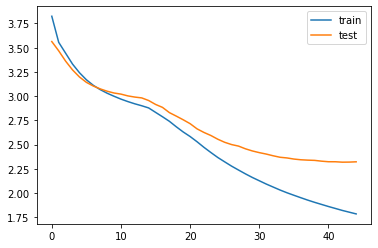

In [119]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [120]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [121]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [122]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [123]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [124]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2summary(input_seq):
    sostoken_idx = tar_word_to_index['sostoken']  # 예시로 설정한 sostoken의 인덱스 값
    eostoken_idx = tar_word_to_index['eostoken']  # 예시로 설정한 eostoken의 인덱스 값
    
    temp = ''
    for i in input_seq:
        if (i != 0) and (i != sostoken_idx) and (i != eostoken_idx):
            temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()


In [125]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former defence minister manohar parrikar said government conducting trials introducing air soldiers indian special forces special forces operation exercise body uncomfortable air jacket comfortable parrikar said explaining need 
실제 요약 : army special forces to get ex defence minister
예측 요약 :  air india to give soldiers to soldiers who soldiers to soldiers


원문 : year old girl allegedly raped father delivered baby boy gujarat monday adding girl newborn healthy hospital staffer said medical team section normal delivery could reportedly newborn would sent girl complete education 
실제 요약 : year old girl raped by father baby in gujarat
예측 요약 :  girl girl in class girl dies after being beaten by school


원문 : union human resource development minister prakash javadekar announced addition seats residential schools primarily focused rural children academic session biggest ever expansion quality education rural students javadekar said announcement currently seats 
실제 요약 : government adds seat

### summarize 사용하기

In [146]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [163]:
data1 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [168]:
data1_text = data1['text'].iloc[i]
summarize(data1_text, ratio =0.9)

'Prime Minister Narendra Modi on Wednesday said his government\'s demonetisation decision made houses affordable for the aspiring youth.\nHe added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".'

In [167]:
summarize(data1['text'].iloc[0], words = 10)

"upGrad's Online Power Learning has powered 3 lakh+ careers."

In [175]:
from summa.summarizer import summarize

# 모델 요약과 Summa 요약을 비교
for i in range(50, 100):
    # 모델을 사용한 요약 생성
    original_text = seq2text(encoder_input_test[i])
    actual_summary = seq2summary(decoder_input_test[i])
    predicted_summary = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    
    # Summa를 사용한 요약 생성
    summa_summary = ""
    data1_text = data1['text'].iloc[i]  # data1에서 텍스트 가져오기
    if len(data1_text.split()) > 50:  # 원문이 충분히 길 경우에만 요약 시도
        summa_summary = summarize(data1_text, ratio = 0.6)  # 요약 비율 20%로 설정
    
    if not summa_summary.strip():
        summa_summary = "Summa 요약이 생성되지 않았습니다."
    
    # 결과 출력
    print(f"원문 [{i}]:", original_text)
    print(f"실제 요약 [{i}]:", actual_summary)
    print(f"모델 예측 요약 [{i}]:", predicted_summary)
    print(f"Summa 요약 [{i}]:", summa_summary)
    print("\n" + "="*100 + "\n")

원문 [50]: former defence minister manohar parrikar said government conducting trials introducing air soldiers indian special forces special forces operation exercise body uncomfortable air jacket comfortable parrikar said explaining need 
실제 요약 [50]: army special forces to get ex defence minister
모델 예측 요약 [50]:  air india to give soldiers to soldiers who soldiers to soldiers
Summa 요약 [50]: Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 [51]: year old girl allegedly raped father delivered baby boy gujarat monday adding girl newborn healthy hospital staffer said medical team section normal delivery could reportedly newborn would sent girl complete education 
실제 요약 [51]: year old girl raped by father baby in gujarat
모델 예측 요약 [51]:  girl girl in class girl dies after being beaten by school
Summa 요약 [51]: Boeing retained its position as the world's largest planemaker for the

In [173]:
seq2text(encoder_input_test[50])

'former defence minister manohar parrikar said government conducting trials introducing air soldiers indian special forces special forces operation exercise body uncomfortable air jacket comfortable parrikar said explaining need '

In [174]:
data1.iloc[50]

headlines    Yashwant Sinha demands probe into alleged fund...
text         Former Finance Minister Yashwant Sinha on Tues...
Name: 50, dtype: object

인덱스가 같은걸 확인함

## 회고
summarize 전까지는 금방왔는데, summarize에서는 뭐가 문제인지 몰라서 되게 오랜시간을 많이 먹었다.

1. summarize를 할때는 전처리를 안한 원본데이터를 꼭 넣어야 한다.
2. 키에러가 났을때는 모델을 잘 구성해야한다.

텍스트 데이터 너무 어렵다.

에러 메시지를 잘 보자는 생각을 잘 한거 같다.